!pip install pydantic
!pip install PyYAML
!pip install jinja2
!pip install visions
!pip install htmlmin
!pip install phik
!pip install requests
!pip install tqdm
!pip install seaborn
!pip install multimethod
!pip install statsmodels
!pip install typeguard
!pip install imagehash
!pip install wordcloud
!pip install dacite
!pip install numba

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [6]:
modeldf2019 = pd.read_csv('mydata/MMSA2019.csv',encoding='latin-1')
modeldf2021 = pd.read_csv('mydata/MMSA2021.csv',encoding='latin-1')

In [7]:
#pd.set_option('display.max_columns', None)

In [8]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [10]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210771 entries, 0 to 210770
Data columns (total 180 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    Unnamed: 0  210771 non-null  int64  
 1    DISPCODE    210771 non-null  int64  
 2    STATERE1    71738 non-null   float64
 3    CELPHONE    71738 non-null   float64
 4    LADULT1     71738 non-null   float64
 5    COLGSEX     21 non-null      float64
 6    LANDSEX     30365 non-null   float64
 7    RESPSLCT    36285 non-null   float64
 8    SAFETIME    139033 non-null  float64
 9    CADULT1     139033 non-null  float64
 10   CELLSEX     139026 non-null  float64
 11   HHADULT     139028 non-null  float64
 12   SEXVAR      210771 non-null  int64  
 13   GENHLTH     210753 non-null  float64
 14   PHYSHLTH    210750 non-null  float64
 15   MENTHLTH    210761 non-null  float64
 16   POORHLTH    116171 non-null  float64
 17   HLTHPLN1    210764 non-null  float64
 18   PERSDOC2    210765 non

In [11]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227792 entries, 0 to 227791
Data columns (total 153 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    Unnamed: 0  227792 non-null  int64  
 1    DISPCODE    227792 non-null  int64  
 2    STATERE1    55524 non-null   float64
 3    CELPHON1    55524 non-null   float64
 4    LADULT1     55524 non-null   float64
 5    COLGSEX     18 non-null      float64
 6    LANDSEX     23345 non-null   float64
 7    RESPSLCT    30824 non-null   float64
 8    SAFETIME    172268 non-null  float64
 9    CADULT1     172268 non-null  float64
 10   CELLSEX     172267 non-null  float64
 11   HHADULT     172267 non-null  float64
 12   SEXVAR      227792 non-null  int64  
 13   GENHLTH     227790 non-null  float64
 14   PHYSHLTH    227790 non-null  float64
 15   MENTHLTH    227792 non-null  int64  
 16   POORHLTH    122851 non-null  float64
 17   PRIMINSR    227791 non-null  float64
 18   PERSDOC3    227792 non

### Merging 2019 and 2021 BRFSS Dataframes Using Columns of Interest

In [12]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [13]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [14]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4','EXERANY2', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

42

In [15]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [16]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [17]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# Concatenate DataFrames based on common columns
brfss_df = pd.concat([modeldf2019[common_columns], modeldf2021[common_columns]],ignore_index=True )


In [18]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC','ALCDAY5']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [19]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438563 entries, 0 to 438562
Data columns (total 137 columns):
 #    Column      Non-Null Count   Dtype   
---   ------      --------------   -----   
 0    Unnamed: 0  438563 non-null  int64   
 1    DISPCODE    438563 non-null  category
 2    STATERE1    127262 non-null  category
 3    LADULT1     127262 non-null  float64 
 4    COLGSEX     39 non-null      category
 5    LANDSEX     53710 non-null   float64 
 6    RESPSLCT    67109 non-null   float64 
 7    SAFETIME    311301 non-null  category
 8    CADULT1     311301 non-null  category
 9    CELLSEX     311293 non-null  float64 
 10   HHADULT     311295 non-null  float64 
 11   SEXVAR      438563 non-null  category
 12   GENHLTH     438543 non-null  category
 13   PHYSHLTH    438540 non-null  category
 14   MENTHLTH    438553 non-null  category
 15   POORHLTH    239022 non-null  float64 
 16   PRIMINSR    438555 non-null  category
 17   MEDCOST1    438556 non-null  category
 18   CH

In [20]:
#Lets make a copy of the merged dataframe
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [21]:
#list(processed_features_df['STATE'].unique())

### Generate EDA Report with Original Dataset

In [22]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

#profile = ProfileReport(modeldf2021)
#profile.to_file(output_file="mydata/EDA_Report_2021.html")

### Data Cleaning Handle Missing data

In [23]:
pd.reset_option('display.max_rows',None)

In [24]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

             Total   Percent
COLGSEX     438524  0.999911
NUMPHON3    404391  0.922082
CAGEG       386802  0.881976
LANDSEX     384853  0.877532
DIABAGE3    383587  0.874645
ASTHNOW     376273  0.857968
RESPSLCT    371454  0.846980
PREGNANT    354313  0.807895
NUMHHOL3    311876  0.711132
STATERE1    311301  0.709820
LADULT1     311301  0.709820
ARTHDIS2    303726  0.692548
LMTJOIN3    303724  0.692544
JOINPAI2    303723  0.692541
ARTHEDU     303723  0.692541
ARTHEXER    303722  0.692539
HIVTSTD3    297800  0.679036
_FLSHOT7    284168  0.647953
_PNEUMO3    284168  0.647953
SMOKDAY2    275829  0.628938
BPMEDS      272503  0.621354
FLSHTMY3    229112  0.522415
MAXDRNKS    219485  0.500464
DRNK3GE5    219040  0.499449
AVEDRNK3    218304  0.497771
POORHLTH    199541  0.454988
CELLSEX     127270  0.290198
HHADULT     127268  0.290193
CADULT1     127262  0.290180
SAFETIME    127262  0.290180
_VEGESU1     60134  0.137116
_RFCHOL3     53817  0.122712
_FRUTSU1     50978  0.116239
VEGEDA2_     4

In [25]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unque vales and may be of no importance to ones health

processed_features_df.drop(columns=['SAFETIME','CELLSEX','DISPCODE','_MMSA','_MMSAWT'],inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438563 entries, 0 to 438562
Data columns (total 106 columns):
 #    Column      Non-Null Count   Dtype   
---   ------      --------------   -----   
 0    Unnamed: 0  438563 non-null  int64   
 1    CADULT1     311301 non-null  category
 2    HHADULT     311295 non-null  float64 
 3    SEXVAR      438563 non-null  category
 4    GENHLTH     438543 non-null  category
 5    PHYSHLTH    438540 non-null  category
 6    MENTHLTH    438553 non-null  category
 7    PRIMINSR    438555 non-null  category
 8    MEDCOST1    438556 non-null  category
 9    CHECKUP1    438555 non-null  float64 
 10   CVDINFR4    438555 non-null  float64 
 11   CVDCRHD4    438556 non-null  float64 
 12   CVDSTRK3    438554 non-null  float64 
 13   ASTHMA3     438556 non-null  float64 
 14   CHCSCNCR    438556 non-null  float64 
 15   CHCOCNCR    438555 non-null  float64 
 16   ADDEPEV3    438555 non-null  float64 
 17   CHCKDNY2    438555 non-null  float64 
 18   DI

##### Vegetable and fruit columns calculated from other veg_fruit columns (So we will keep only these ones)
     'FRNCHDA_'- french fry intake in time per day 2
     'POTADA1_' - computed potatoe servings per day 
     'FRUTDA2_',- number of fruits consunmed per day 
     'FTJUDA2_'- computed fruit juice intake in times per day 
     'VEGEDA2_', - COMPUTED NUMBER OF OTHER VEGIES eaten per day - not lettuce or potatoe 
     'GRENDA1_'- Number of dark green vegetables per day Times per day  
     'FRUTSU1', Number of Fruits consumed per day 
     'VEGESU1', Number of Vegetables consumed per day 


In [26]:
#Drop redundant Columns and irreleveant columns
processed_features_df.drop(columns=['SEQNO','_AGE80','_AGE65YR','_AGE_G','SEXVAR',
                                    'WEIGHT2','_CASTHM1','_LTASTH1','PRIMINSR','EXERANY2','CHILDREN','EDUCA',
                                    'ASTHMA3','SMOKE100','CPDEMO1B','_STSTR','CVDINFR4','CVDCRHD4','_RACEG21'
                                   ,'_RACEGR3','_PRACE1','_MRACE1','_IMPSEX','CADULT1','GENHLTH',
                                    'HHADULT','_RFBMI5','VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2','HIVTST7'],inplace=True)

<Axes: >

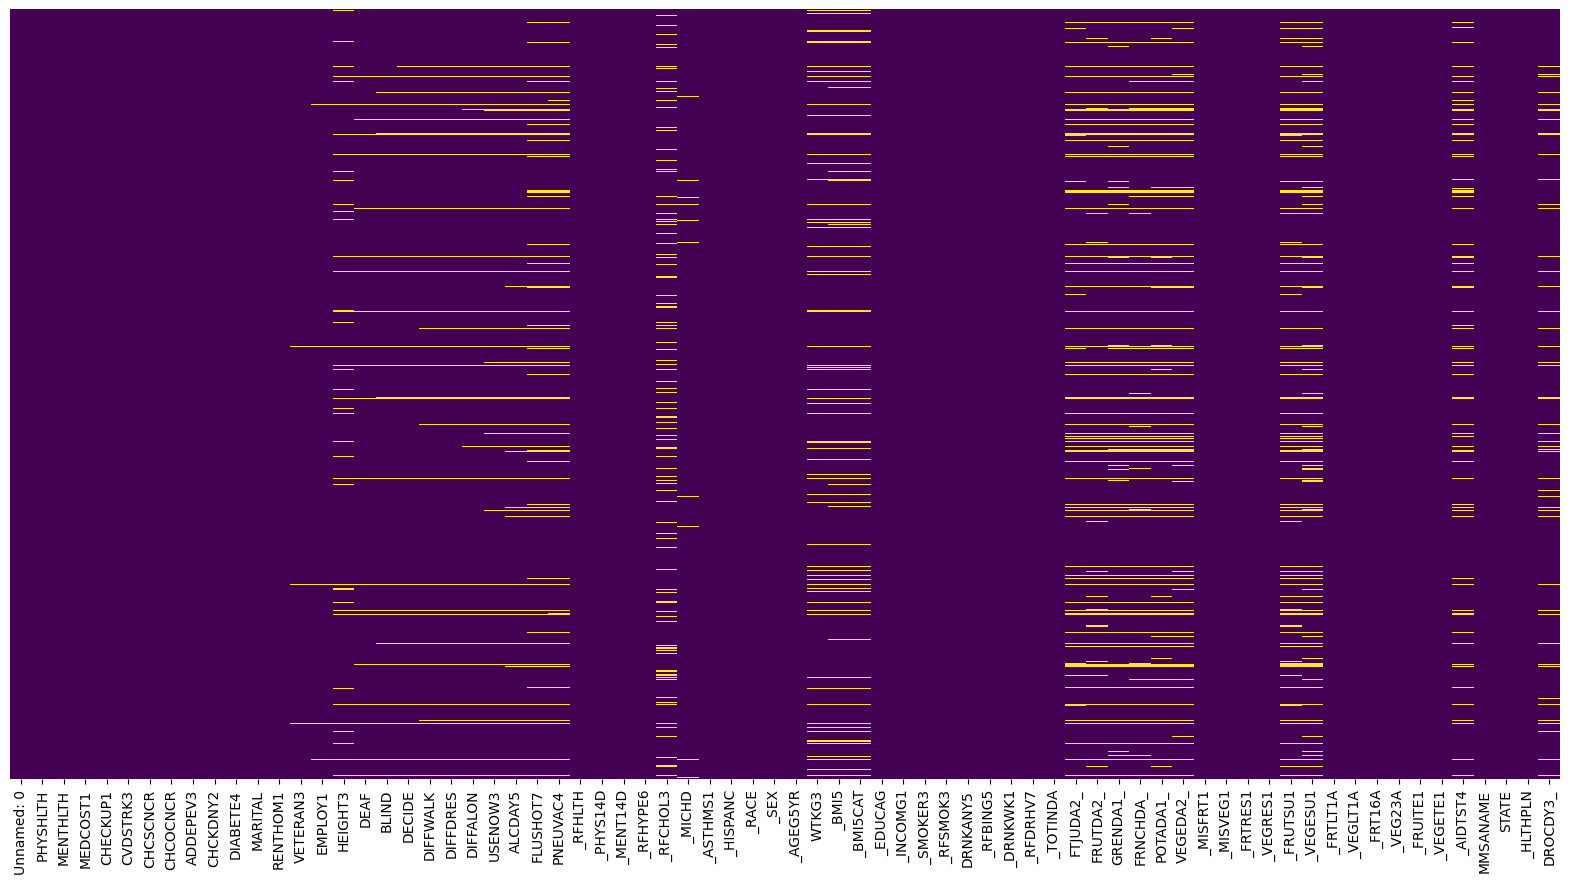

In [27]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [28]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 

#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)

In [29]:
print(missing_data.to_string())

            Total   Percent
_VEGESU1    60134  0.137116
_RFCHOL3    53817  0.122712
_FRUTSU1    50978  0.116239
VEGEDA2_    49591  0.113076
POTADA1_    48821  0.111320
_BMI5CAT    45787  0.104402
_BMI5       45787  0.104402
FRNCHDA_    45286  0.103260
FTJUDA2_    44884  0.102343
GRENDA1_    44802  0.102156
FRUTDA2_    44402  0.101244
WTKG3       38540  0.087878
_AIDTST4    38393  0.087543
PNEUVAC4    36398  0.082994
FLUSHOT7    34963  0.079722
DROCDY3_    29332  0.066882
HEIGHT3     27209  0.062041
ALCDAY5     23696  0.054031
USENOW3     21352  0.048686
DIFFALON    19229  0.043845
DIFFDRES    18243  0.041597
DIFFWALK    17489  0.039878
DECIDE      16389  0.037370
BLIND       15355  0.035012
DEAF        14281  0.032563
_MICHD       4283  0.009766
EMPLOY1      3581  0.008165
VETERAN3     1672  0.003812
MARITAL        34  0.000078
PHYSHLTH       23  0.000052
RENTHOM1       20  0.000046
MENTHLTH       10  0.000023
CVDSTRK3        9  0.000021
CHECKUP1        8  0.000018
CHCKDNY2        8  0

In [30]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Calculate mean height values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['HEIGHT3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['HEIGHT3'].mean()

# Replace missing values with the corresponding mean height value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_women

In [31]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG

# Calculate mean weight values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['WTKG3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['WTKG3'].mean()

# Replace missing values with the corresponding mean weight value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_women

In [32]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 1
    elif 18.50 <= _BMI5 < 25.00:
        return 2
    elif 25.00 <= _BMI5 < 30.00:
        return 3
    elif _BMI5 >= 30.00:
        return 4
    else:
        return None  # Handle other possible cases (e.g. negative BMI or None)

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')
processed_features_df.drop(columns='_BMI5',inplace=True)

In [33]:
#Drop rows where these columns are null
column_names = [
    "MENTHLTH",
    "ADDEPEV3",
    "CHECKUP1",
    "CVDSTRK3",
    "DIABETE4",
    "_HLTHPLN",
    "MEDCOST1",
    "CHCSCNCR",
    "CHCOCNCR",
    "CHCKDNY2",
    "_RACE"
]
processed_features_df.dropna(subset=column_names,inplace=True)

In [34]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [35]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_']

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [36]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [37]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
#processed_features_df.info()

<Axes: >

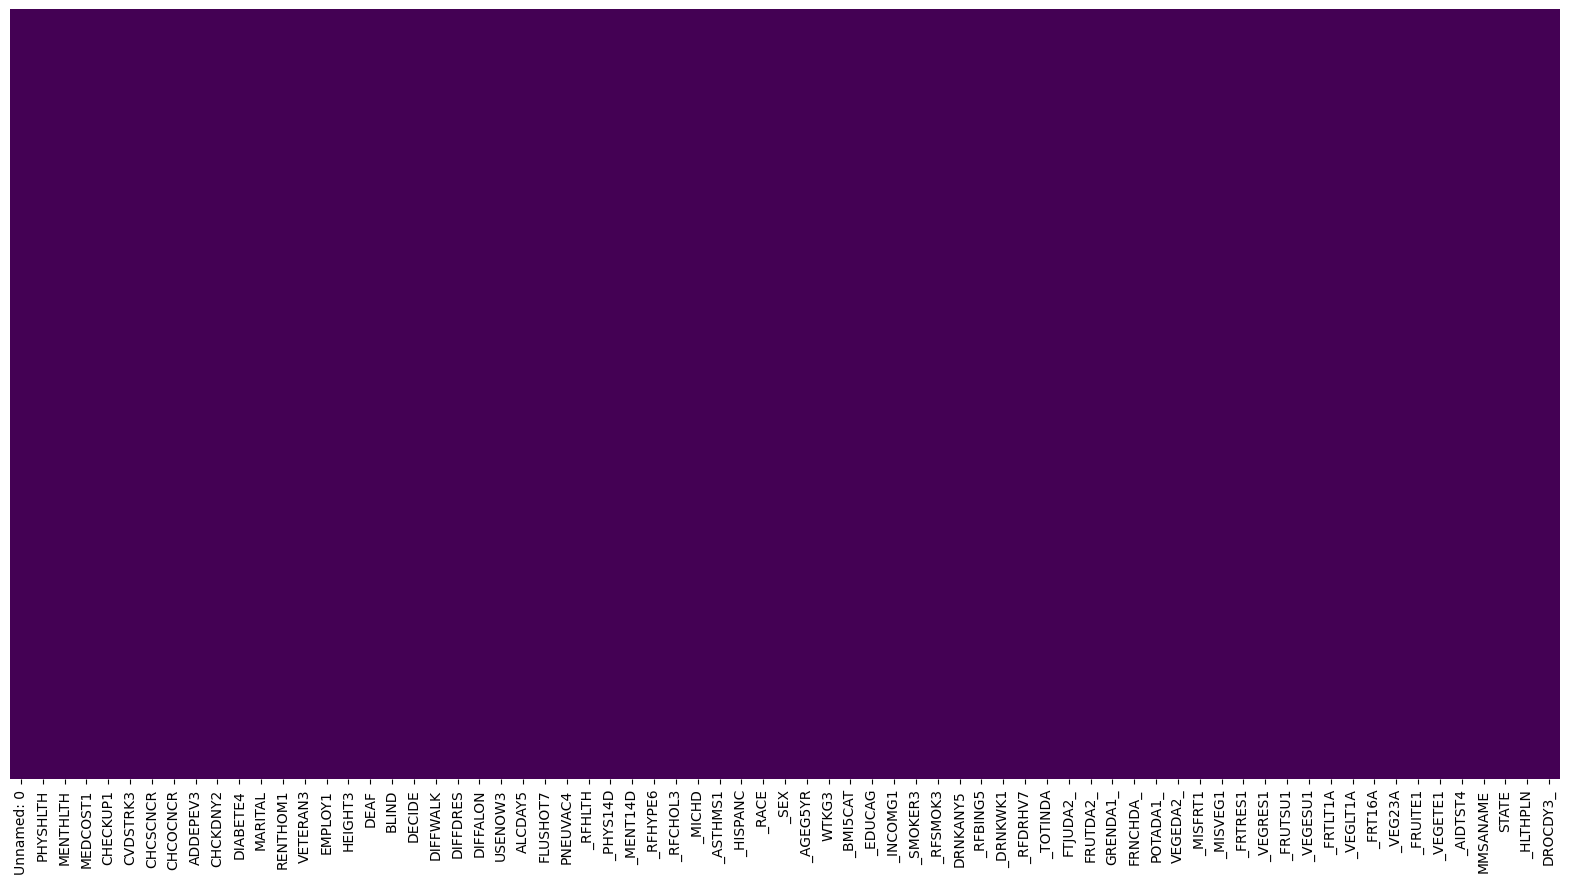

In [38]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [39]:
#Lets Generate A profile report of the cleaned data
#profile = ProfileReport(processed_features_df,minimal=True,dark_mode=True)
#profile.to_file(output_file="EDA_Report_Cleaned.html")

In [46]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391231 entries, 0 to 438562
Data columns (total 71 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Unnamed: 0  391231 non-null  int64   
 1   PHYSHLTH    391231 non-null  category
 2   MENTHLTH    391231 non-null  category
 3   MEDCOST1    391231 non-null  category
 4   CHECKUP1    391231 non-null  float64 
 5   CVDSTRK3    391231 non-null  float64 
 6   CHCSCNCR    391231 non-null  float64 
 7   CHCOCNCR    391231 non-null  float64 
 8   ADDEPEV3    391231 non-null  float64 
 9   CHCKDNY2    391231 non-null  float64 
 10  DIABETE4    391231 non-null  float64 
 11  MARITAL     391231 non-null  category
 12  RENTHOM1    391231 non-null  category
 13  VETERAN3    391231 non-null  category
 14  EMPLOY1     391231 non-null  category
 15  HEIGHT3     391231 non-null  float64 
 16  DEAF        391231 non-null  category
 17  BLIND       391231 non-null  category
 18  DECIDE      391231 non-n

In [41]:
processed_features_df.to_csv('mydata/MMSA2019_2021_Cleaned.csv', index=False)

In [42]:
processed_features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,391231.0,110011.286307,63689.772510,1.0000,54867.5000,109676.000000,165004.000,227792.000
CHECKUP1,391231.0,1.433519,1.066829,1.0000,1.0000,1.000000,1.000,9.000
CVDSTRK3,391231.0,1.972791,0.301668,1.0000,2.0000,2.000000,2.000,9.000
CHCSCNCR,391231.0,1.918261,0.385879,1.0000,2.0000,2.000000,2.000,9.000
CHCOCNCR,391231.0,1.914651,0.388111,1.0000,2.0000,2.000000,2.000,9.000
ADDEPEV3,391231.0,1.829063,0.553034,1.0000,2.0000,2.000000,2.000,9.000
CHCKDNY2,391231.0,1.978660,0.342026,1.0000,2.0000,2.000000,2.000,9.000
DIABETE4,391231.0,2.766169,0.713171,1.0000,3.0000,3.000000,3.000,9.000
HEIGHT3,391231.0,1.701693,0.105403,0.9144,1.6256,1.701800,1.778,2.413
_RACE,391231.0,2.227638,2.470411,1.0000,1.0000,1.000000,2.000,9.000


In [43]:
#Remove the Outliers from Numerical Data Columns

In [44]:
num_cols = processed_features_df.select_dtypes(include='float').columns

<Axes: >

<Figure size 1200x800 with 0 Axes>

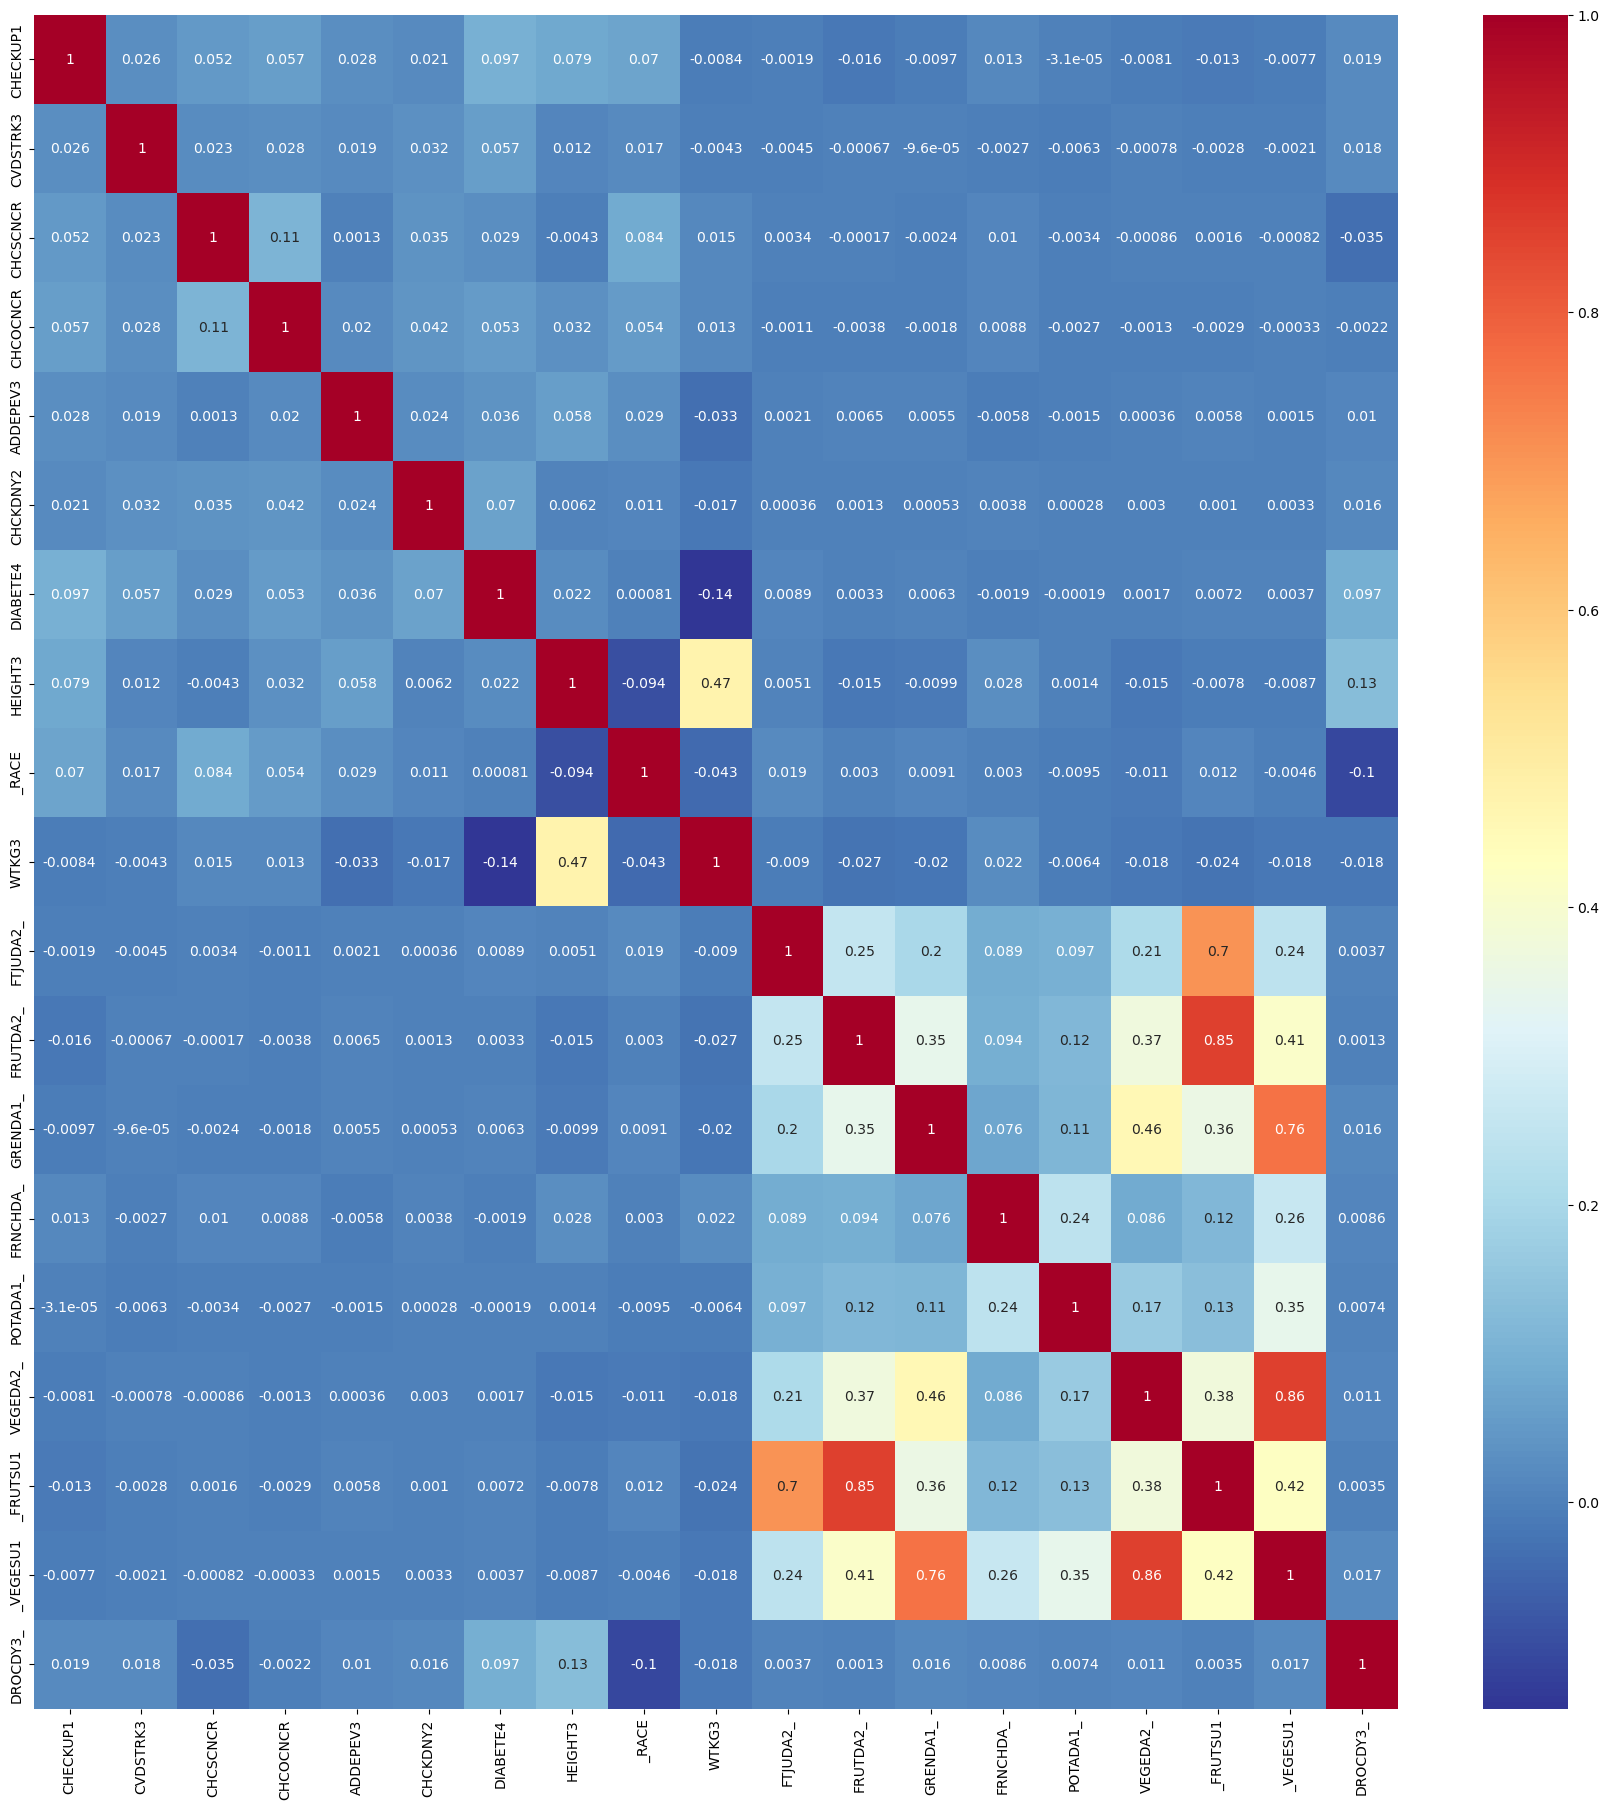

In [56]:
#Chesk for correlation between the numeric vairbales 
plt.figure(figsize=(12,8))
plt.figure(figsize=(22,22))
sns.heatmap(processed_features_df[num_cols].corr(),cmap='RdYlBu_r',annot=True)

##### We can see the presence of significant multicolinearity between the fruits and vegetable columns 